## Traсking Error

In [43]:
import yapo
import pandas as pd
import numpy as np


### Список фондов

| # | Название | Тикер | Переменная |
| --- | --- | --- | --- |
| 1 | АК БАРС ИНДЕКСНЫЙ  | mut_ru/0295-74549871 | pif_acbar |
| 2 | Аллтек - Биржевой индекс акций  | mut_ru/0662-94119196 | pif_altec |
| 3 | Альфа–Капитал Индекс МосБиржи  | mut_ru/0695-94121916 | pif_alfa |
| 4 | БКС Индекс МосБиржи  | mut_ru/0278-58233720 | pif_bcs |
| 5 | ВТБ - Индекс МосБиржи  | mut_ru/0177-71671092 | pif_vtb |
| 6 | Ингосстрах Индекс МосБиржи  | mut_ru/1149-94139555 | pif_ingos |
| 7 | Открытие – Индекс МосБиржи  | mut_ru/0890-94127385 | pif_otkrit |
| 8 | **Райффайзен – Индекс ММВБ голубых фишек**  | mut_ru/0983-94131725 | pif_raif |
| 9 | Сбербанк - Индекс МосБиржи полной доходности брутто  | micex/SBMX | pif_sber |
| 10 | Cолид - Индекс МосБиржи   | mut_ru/0351-76578546 | pif_solid |
| 11 | **ОЛМА – ИНДЕКС РТС**  | mut_ru/0456-93270471 | pif_olma |


In [44]:
sber = yapo.portfolio_asset(name='micex/SBMX')

In [45]:
sber.rate_of_return().start_period

Period('2018-10', 'M')

In [46]:
micex = yapo.portfolio_asset(name='index/MCFTR', start_period=sber.rate_of_return().start_period-1) # выравниваем по дате начала

In [47]:
micex.close().start_period

Period('2018-09', 'M')

In [48]:
micex.rate_of_return().start_period

Period('2018-10', 'M')

### Определяем портфель и размер периода

In [49]:
start_period = '2008-12'

In [50]:
portfolio = yapo.portfolio(assets={'mut_ru/0295-74549871': .1,
                                   'mut_ru/0662-94119196': .1,
                                   'mut_ru/0695-94121916': .1,
                                   'mut_ru/0278-58233720': .1,
                                   'mut_ru/0177-71671092': .1,
                                   'mut_ru/1149-94139555': .1,
                                   'mut_ru/0890-94127385': .1,
                                   'mut_ru/0983-94131725': .1,
                                   'mut_ru/0351-76578546': .1,
                                   'mut_ru/0456-93270471': .1,
                                   'index/MCFTR': .1},
                           start_period=start_period, currency='RUB')

In [51]:
portfolio.assets['mut_ru/0295-74549871'].symbol.short_name

'АК БАРС Индексный'

In [52]:
portfolio.rate_of_return().start_period # самый короткий период у pif_ingos

Period('2009-01', 'M')

In [53]:
N = (portfolio.rate_of_return().end_period - portfolio.rate_of_return().start_period) # максимальный период для этого набора активови

In [54]:
# Better: 
len(portfolio.rate_of_return().period_range())

121

In [55]:
N

120

In [56]:
N / 12

10.0

In [57]:
portfolio.assets['index/MCFTR'].rate_of_return(kind = 'accumulated').values[-2:]

array([4.74231689, 5.12650288])

In [58]:
portfolio.assets['index/MCFTR'].compound_annual_growth_rate()

TimeSeries(start_period=2009-01, end_period=2019-01, kind=TimeSeriesKind.REDUCED_VALUE, values=[0.1987297]

In [59]:
(0.1987297+1)**10-1

5.126503083150756

### Функции: ошибка следования и разница в накопленной доходности

In [60]:
def tracking_error (fond, index='index/MCFTR'): # по умолчанию второй аргумент - индекс Мосбиржи
    fond_ror = portfolio.assets[fond].rate_of_return()
    index_ror = portfolio.assets[index].rate_of_return()
    x = (((fond_ror - index_ror) ** 2).sum() / (N-1)).sqrt()
    return x * 12**(.5)


In [61]:
def tracking_difference (fond, index='index/MCFTR'): # по умолчанию второй аргумент - индекс Мосбиржи
    fond_ror = portfolio.assets[fond].rate_of_return(kind='accumulated')
    index_ror = portfolio.assets[index].rate_of_return(kind='accumulated')
    return fond_ror - index_ror

In [62]:
def tracking_difference_annualized(fond, index='index/MCFTR'): # по умолчанию второй аргумент - индекс Мосбиржи
    x = tracking_difference(fond, index).values
    y = abs(x)
    M = (portfolio.rate_of_return().end_period - portfolio.rate_of_return().start_period)
    return np.sign(x)*((y+1)**(1/(M/12))-1)

In [63]:
tracking_error('mut_ru/0177-71671092').values[0]

0.03921823889677477

In [64]:
tracking_difference('mut_ru/0177-71671092').values[-1]

-1.0059100593688743

In [65]:
tracking_difference_annualized('mut_ru/0177-71671092')[-1]

-0.0720897544101502

### DataFrame с данными по отклонению для портфеля

In [66]:
df1 = pd.DataFrame()

In [67]:
for asset in portfolio.assets:
        row = {'Tracking Error':tracking_error(asset).values[0], 
               'Tracking Difference':tracking_difference(asset)[-1], 
               'Tracking Difference A':tracking_difference_annualized(asset)[-1], 
               'Name':portfolio.assets[asset].symbol.short_name}
        df1 = df1.append(row, ignore_index=True)  

In [68]:
df1

Name  Tracking Difference  \
0                              АК БАРС Индексный            -1.258071   
1                 Аллтек - Биржевой индекс акций            -0.757663   
2                  Альфа–Капитал Индекс МосБиржи            -2.481123   
3                            БКС Индекс МосБиржи            -0.933071   
4                          ВТБ - Индекс МосБиржи            -1.005910   
5                     Ингосстрах Индекс МосБиржи            -1.046675   
6                     Открытие – Индекс МосБиржи            -0.930173   
7         Райффайзен – Индекс ММВБ голубых фишек            -1.342964   
8   Солид - Индекс МосБиржи  можно купить online            -0.696589   
9                              ОЛМА – ИНДЕКС РТС            -1.336839   
10    Индекс МосБиржи полной доходности "брутто"             0.000000   

    Tracking Difference A  Tracking Error  
0               -0.084860        0.041490  
1               -0.058019        0.069466  
2               -0.132849        0.061640  
3               -0.068132        0.040076  
4               -0.072090        0.039218  
5               -0.074249        0.039437  
6               -0.067971        0.041899  
7               -0.088871        0.040232  
8               -0.054284        0.046953  
9               -0.088586        0.064607  
10               0.000000        0.000000

In [307]:
from pandas import ExcelWriter

df1.to_csv('output_csv', sep=',')

### Ошибка для Сбера

In [69]:
portfolio = yapo.portfolio(assets={'micex/SBMX': .1,
                                   'index/MCFTR': .1},
                           currency='RUB')

In [70]:
N = (portfolio.rate_of_return().end_period - portfolio1.rate_of_return().start_period)

NameError: name 'portfolio1' is not defined

In [71]:
N

120

In [72]:
portfolio.rate_of_return().start_period

Period('2018-10', 'M')

In [73]:
tracking_error('micex/SBMX').values[0]

0.0011135264226332247

In [295]:
tracking_difference('micex/SBMX').values

array([0.00153891, 0.00060477, 0.00324836, 0.00225484])

In [296]:
tracking_difference_annualized('micex/SBMX')[-1]

0.009049925926039704

### Бета

In [84]:
def beta (fond, index='index/MCFTR'): # по умолчанию второй аргумент - индекс Мосбиржи
    x = np.corrcoef(portfolio.assets[fond].rate_of_return().values,portfolio.assets[index].rate_of_return().values)
    risk_fond = portfolio.assets[fond].risk(period='year')
    risk_index = portfolio.assets[index].risk(period='year')
    return x[1,0]*risk_fond/risk_index

In [85]:
beta('mut_ru/0295-74549871')

TimeSeries(start_period=2009-02, end_period=2019-01, kind=TimeSeriesKind.REDUCED_VALUE, values=[0.94912229]

In [86]:
df2 = pd.DataFrame()

In [87]:
for asset in portfolio.assets:
        row = {'Name':portfolio.assets[asset].symbol.short_name,
               'Beta':beta(asset).values[0]}
        df2 = df2.append(row, ignore_index=True)  

In [88]:
df2

Beta                                          Name
0   0.949122                             АК БАРС Индексный
1   0.913195                Аллтек - Биржевой индекс акций
2   0.841951                 Альфа–Капитал Индекс МосБиржи
3   0.934906                           БКС Индекс МосБиржи
4   0.938452                         ВТБ - Индекс МосБиржи
5   0.927945                    Ингосстрах Индекс МосБиржи
6   0.958163                    Открытие – Индекс МосБиржи
7   0.940034        Райффайзен – Индекс ММВБ голубых фишек
8   0.970611  Солид - Индекс МосБиржи  можно купить online
9   0.987601                             ОЛМА – ИНДЕКС РТС
10  1.000000    Индекс МосБиржи полной доходности "брутто"

### Рисование графика

In [242]:
%matplotlib inline
import matplotlib.pyplot as plt

In [243]:
portfolio.rate_of_return().start_period

Period('2014-01', 'M')

In [244]:
portfolio.assets['mut_ru/0295-74549871'].rate_of_return(kind='accumulated').values[:10]

array([-0.02228606, -0.03798714, -0.09376858, -0.12912013, -0.03509442,
       -0.00649257, -0.0457051 , -0.02164323, -0.0306147 , -0.00652069])

| # | Название | Тикер | Переменная |
| --- | --- | --- | --- |
| 1 | АК БАРС ИНДЕКСНЫЙ  | mut_ru/0295-74549871 | pif_acbar |
| 2 | Аллтек - Биржевой индекс акций  | mut_ru/0662-94119196 | pif_altec |
| 3 | Альфа–Капитал Индекс МосБиржи  | mut_ru/0695-94121916 | pif_alfa |
| 4 | БКС Индекс МосБиржи  | mut_ru/0278-58233720 | pif_bcs |
| 5 | ВТБ - Индекс МосБиржи  | mut_ru/0177-71671092 | pif_vtb |
| 6 | Ингосстрах Индекс МосБиржи  | mut_ru/1149-94139555 | pif_ingos |
| 7 | Открытие – Индекс МосБиржи  | mut_ru/0890-94127385 | pif_otkrit |
| 8 | **Райффайзен – Индекс ММВБ голубых фишек**  | mut_ru/0983-94131725 | pif_raif |
| 9 | Сбербанк - Индекс МосБиржи полной доходности брутто  | micex/SBMX | pif_sber |
| 10 | Cолид - Индекс МосБиржи   | mut_ru/0351-76578546 | pif_solid |
| 11 | **ОЛМА – ИНДЕКС РТС**  | mut_ru/0456-93270471 | pif_olma |

In [340]:
df = pd.DataFrame({
    'Дата': pd.period_range(portfolio.rate_of_return().start_period, portfolio.rate_of_return().end_period, freq='M'), 
    'АК БАРС Индексный': portfolio.assets['mut_ru/0295-74549871'].rate_of_return(kind='accumulated').values,
    'Аллтек - Биржевой индекс акций': portfolio.assets['mut_ru/0662-94119196'].rate_of_return(kind='accumulated').values,
    'Альфа–Капитал Индекс МосБиржи': portfolio.assets['mut_ru/0695-94121916'].rate_of_return(kind='accumulated').values,
    'БКС Индекс МосБиржи': portfolio.assets['mut_ru/0278-58233720'].rate_of_return(kind='accumulated').values,
    'ВТБ - Индекс МосБиржи': portfolio.assets['mut_ru/0177-71671092'].rate_of_return(kind='accumulated').values,
    'Ингосстрах Индекс МосБиржи': portfolio.assets['mut_ru/1149-94139555'].rate_of_return(kind='accumulated').values,
    'Открытие – Индекс МосБиржи': portfolio.assets['mut_ru/0890-94127385'].rate_of_return(kind='accumulated').values,
    'Райффайзен – Индекс ММВБ голубых фишек': portfolio.assets['mut_ru/0983-94131725'].rate_of_return(kind='accumulated').values,
    'Cолид - Индекс МосБиржи': portfolio.assets['mut_ru/0351-76578546'].rate_of_return(kind='accumulated').values,
    'Индекс МосБиржи полной доходности': portfolio.assets['index/MCFTR'].rate_of_return(kind='accumulated').values,
})


In [341]:
df.set_index('Дата').tail(10)

АК БАРС Индексный  Аллтек - Биржевой индекс акций  \
Дата                                                         
2018-04           3.191129                        3.601817   
2018-05           3.193174                        3.618159   
2018-06           3.248145                        3.585335   
2018-07           3.409636                        3.723688   
2018-08           3.412860                        3.859111   
2018-09           3.693434                        4.135085   
2018-10           3.534863                        3.897682   
2018-11           3.594257                        3.919660   
2018-12           3.585233                        3.876605   
2019-01           3.868432                        4.368840   

         Альфа–Капитал Индекс МосБиржи  БКС Индекс МосБиржи  \
Дата                                                          
2018-04                       2.158583             3.512027   
2018-05                       2.170166             3.514089   
2018-06                       2.197700             3.554872   
2018-07                       2.314235             3.716830   
2018-08                       2.335259             3.760177   
2018-09                       2.527238             4.011776   
2018-10                       2.390102             3.810038   
2018-11                       2.430460             3.885976   
2018-12                       2.422428             3.864062   
2019-01                       2.645379             4.193432   

         ВТБ - Индекс МосБиржи  Ингосстрах Индекс МосБиржи  \
Дата                                                         
2018-04               3.431880                    3.388818   
2018-05               3.415711                    3.394576   
2018-06               3.454520                    3.435549   
2018-07               3.613875                    3.600987   
2018-08               3.638506                    3.637732   
2018-09               3.904038                    3.917424   
2018-10               3.701331                    3.699381   
2018-11               3.766661                    3.758835   
2018-12               3.773929                    3.750195   
2019-01               4.120593                    4.079828   

         Открытие – Индекс МосБиржи  Райффайзен – Индекс ММВБ голубых фишек  \
Дата                                                                          
2018-04                    3.505697                                3.099161   
2018-05                    3.519200                                3.114360   
2018-06                    3.554725                                3.169355   
2018-07                    3.713394                                3.315940   
2018-08                    3.754588                                3.351327   
2018-09                    4.014462                                3.641034   
2018-10                    3.823555                                3.421096   
2018-11                    3.896056                                3.476923   
2018-12                    3.880553                                3.472491   
2019-01                    4.196330                                3.783539   

         Cолид - Индекс МосБиржи  Индекс МосБиржи полной доходности  
Дата                                                                 
2018-04                 3.674946                           4.275932  
2018-05                 3.682375                           4.277543  
2018-06                 3.685222                           4.334729  
2018-07                 3.837022                           4.519215  
2018-08                 3.869393                           4.588885  
2018-09                 4.125490                           4.923368  
2018-10                 3.871486                           4.672095  
2018-11                 3.931747                           4.768019  
2018-12                 3.851155                           4.742317  
2019-01                 4.429914           

In [246]:
# df.date = pd.to_datetime(df.date, format='%Y-%m')

Text(0, 0.5, 'Накопленная доходность')

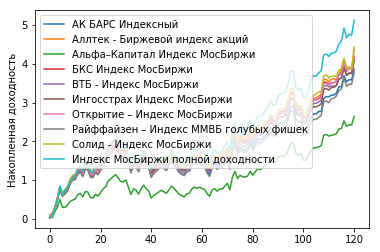

In [351]:
df.plot()
plt.ylabel('Накопленная доходность')

Text(0.5, 0, 'Time (hr)')

Text(0, 0.5, 'Position (km)')

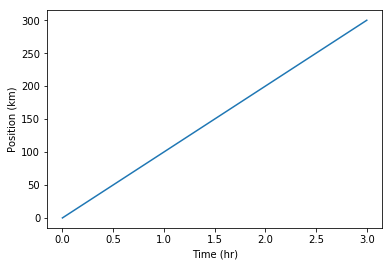

In [248]:
time = [0, 1, 2, 3]
position = [0, 100, 200, 300]

plt.plot(time, position)
plt.xlabel('Time (hr)')
plt.ylabel('Position (km)')